<a href="https://colab.research.google.com/github/liberomne/Home-Credit-Score-Card-Model/blob/main/Home%20Credit%20Score%20Card%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by:
> **Libero Meteora Nefertiri**

> *2025*






#**HOME CREDIT SCORE CARD MODEL**

**Summary Project**:

Home Credit is currently employing a range of statistical methods and machine learning techniques to predict credit scores. It is imperative to unlock the full potential of our data. By doing so, we can ensure that eligible customers with the ability to repay are not unnecessarily rejected during the loan application process.

**Goal**:
1.   Ensuring that customers with the ability to repay loans are not rejected.
2.   Improving the efficiency of credit approvals by minimizing the risk of default.

##**I. Load Libraries**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix, recall_score, roc_curve
)

from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
import shap

from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors

**Datasets Used**


The datasets ***application_train.csv*** and ***application_test.csv*** are designated as the main datasets because they contain the primary information needed to understand and predict customer eligibility for loans. These datasets include key variables such as demographic data, employment status, income, and customer assets, which are essential for assessing credit risk. The ***application_train.csv*** dataset includes a target label (TARGET) indicating whether a customer has successfully repaid a loan or defaulted in the past, making it crucial for training machine learning models. In contrast, the ***application_test.csv*** dataset is used to apply the model to new data in order to predict default risk.

Meanwhile, the other datasets provide additional information, such as payment history or previous transactions, which are more detailed or specific. While this information is useful, it is less directly relevant for building the core credit risk model and could complicate the modeling process, increasing the risk of overfitting. By focusing on these two main datasets, the analysis and modeling process can be conducted more efficiently and effectively, as they already encompass the core data required for a comprehensive credit risk evaluation.

## **II. Main Dataset: Application Train**

In [ ]:
# Load dataset
df_train = pd.read_csv('application_train.csv')

In [ ]:
print('This dataset has %d rows dan %d columns.\n' % df_train.shape)
df_train.head()

This dataset has 307511 rows dan 122 columns.



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### **A. Exploratory Data Analysis (EDA)**

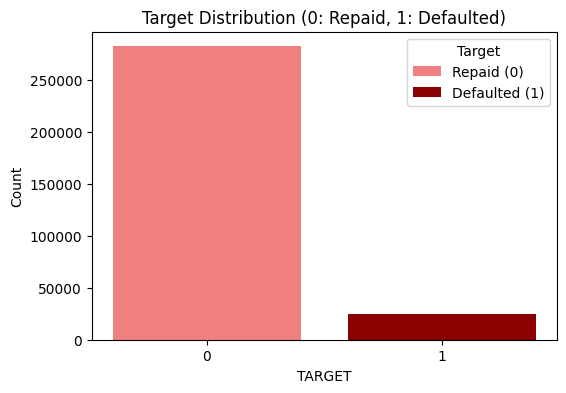

In [ ]:
# Target Distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='TARGET', data=df_train, order=[0, 1])
ax.bar(0, df_train['TARGET'].value_counts()[0], color='lightcoral', label='Repaid (0)')
ax.bar(1, df_train['TARGET'].value_counts()[1], color='darkred', label='Defaulted (1)')

plt.title('Target Distribution (0: Repaid, 1: Defaulted)')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.legend(title='Target')

plt.show()

The graph above illustrates  **the distribution of the target** variable in the application_train.csv dataset, which has two values:

*   **0 (Repaid)**: Indicates customers who successfully repaid their loans
*  **1 (Defaulted)**: Indicates customers who failed to repay their loans.

The graph highlights a significant class imbalance. The majority of the data falls into the 0 (Repaid) class, while only a small portion belongs to the 1 (Defaulted) class. This imbalance indicates that most customers in the dataset successfully repaid their loans, whereas only a small fraction defaulted.

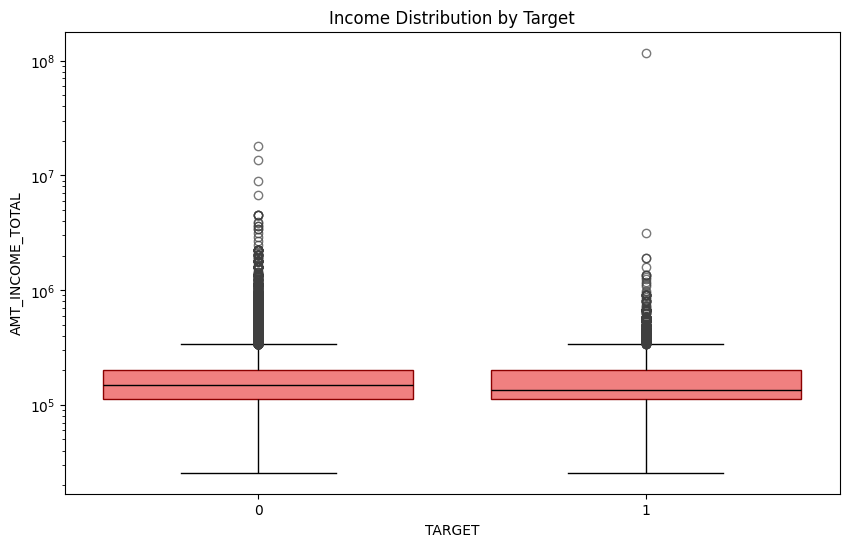

In [ ]:
# Income Distribution by Target
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='TARGET',
    y='AMT_INCOME_TOTAL',
    data=df_train,
    boxprops=dict(facecolor='lightcoral', edgecolor='darkred'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='black'),
    flierprops=dict(marker='o', color='black', alpha=0.7)
)

plt.title('Income Distribution by Target')
plt.yscale('log')
plt.xlabel('TARGET')
plt.ylabel('AMT_INCOME_TOTAL')
plt.show()

This boxplot shows **the distribution of total customer income** (AMT_INCOME_TOTAL) based on the target variable (TARGET):


*   **0 (Repaid)**: Customers who repaid their loans.
*   **1 (Defaulted)**: Customers who defaulted on their loans.

The income distribution is similar for both groups, with nearly identical medians. Most customers, regardless of repayment status, have comparable income levels. Significant outliers are present in both groups, representing customers with much higher incomes than the majority.

A logarithmic scale is used on the Y-axis to better visualize the wide range of income values.

In conclusion, there is no notable difference in income distribution between the two groups, suggesting that total income (AMT_INCOME_TOTAL) may not be a key factor in distinguishing between them.

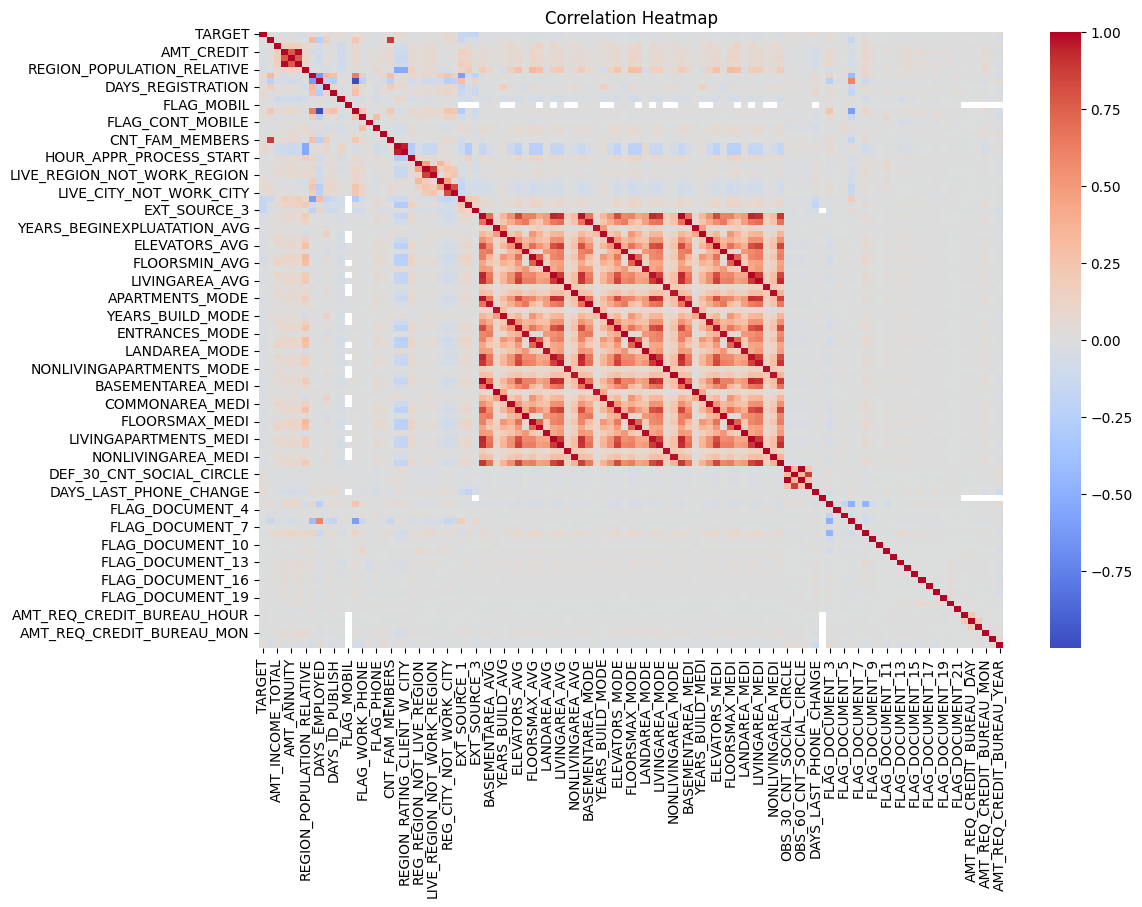

In [ ]:
# Change Data Type
df_train['SK_ID_CURR'] = df_train['SK_ID_CURR'].astype(str)

# Select only numeric columns
numeric_df = df_train.select_dtypes(include=[np.number])

# Calculate correlation
corr = numeric_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap output illustrates **the relationship (correlation) between each pair of numerical variables** in the dataset. Here is a brief explanation:

**Heatmap Colors:**

*   **Red**: Indicates positive correlation (the closer to 1, the stronger the relationship).
*   **Blue**: Indicates negative correlation (the closer to -1, the stronger the inverse relationship).
*  **White/Neutral**: Indicates correlation close to zero (no significant relationship).


**Main Diagonal**:

*   Always has a value of 1.0, as it represents the correlation of a variable with itself.

**High Correlations**:

*   For example, there are several strong correlations among property-related variables, such as APARTMENTS_AVG, LIVINGAREA_AVG, and FLOORSMAX_AVG, which is logical since these variables are physically related.

**Low Correlations**:
*   Variables like TARGET (credit repayment status) generally show low correlation with most other variables, indicating that credit status is influenced by many complex factors rather than a single variable.

This heatmap helps identify pairs of variables with strong relationships (either positive or negative) for further analysis or to avoid multicollinearity when building a model.

###**B. Data Cleaning**

In [ ]:
# Detecting Duplicates
duplicates = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [ ]:
# Handling Missing Values
missing = df_train.isnull().mean().sort_values(ascending=False)
missing_features = missing[missing > 0.3].index  # Drop features with >30% missing
df_train.drop(columns=missing_features, inplace=True)
print(f"Removed {len(missing_features)} columns due to high missing values.")

Removed 50 columns due to high missing values.


In [ ]:
# Imputation for Remaining Missing Values
numerical_columns = df_train.select_dtypes(include=[np.number]).columns
categorical_columns = df_train.select_dtypes(exclude=[np.number]).columns

imputer = SimpleImputer(strategy='median')
df_train[numerical_columns] = imputer.fit_transform(df_train[numerical_columns])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_columns] = cat_imputer.fit_transform(df_train[categorical_columns])

In [ ]:
# Detecting Outliers with Z-Score
z_scores = zscore(df_train.select_dtypes(include=[np.number]))
outliers = (np.abs(z_scores) > 3).sum()
print(f"Number of potential outliers: {outliers.sum()}")

Number of potential outliers: 242343


###**C. Model Building**

In [ ]:
# Encode categorical variables
label_encoders = {}
for col in df_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    label_encoders[col] = le

# Feature Engineering
df_train['INCOME_CREDIT_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
df_train['AGE_YEARS'] = df_train['DAYS_BIRTH'] / -365
df_train['EMPLOYED_YEARS'] = df_train['DAYS_EMPLOYED'] / -365

In [ ]:
# Feature Selection: Remove low-variance features
low_variance_features = df_train.var()[df_train.var() < 0.01].index
df_train.drop(columns=low_variance_features, inplace=True)
print(f"Removed {len(low_variance_features)} low-variance features.")

Removed 0 low-variance features.


In [ ]:
# Splitting Data
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handling Imbalanced Data with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {y_train_resampled.value_counts()}")

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

After SMOTE: TARGET
0.0    226148
1.0    226148
Name: count, dtype: int64


Model: Logistic Regression
AUC Score: 0.6820
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83     56538
         1.0       0.15      0.51      0.23      4965

    accuracy                           0.72     61503
   macro avg       0.55      0.63      0.53     61503
weighted avg       0.88      0.72      0.78     61503



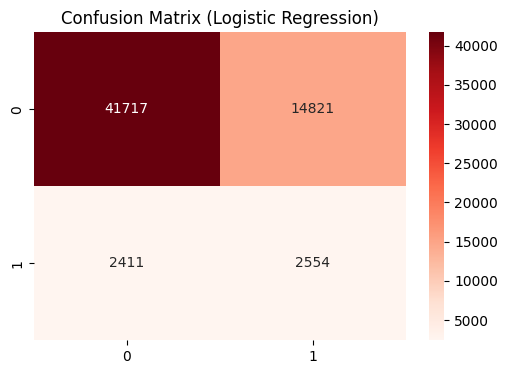

Model: Random Forest
AUC Score: 0.6915
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.37      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.64      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



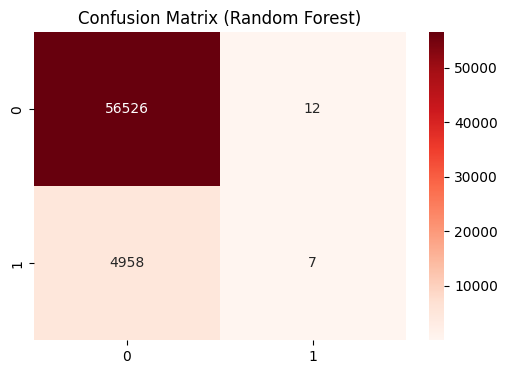

Model: Gradient Boosting
AUC Score: 0.6892
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.32      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.62      0.50      0.48     61503
weighted avg       0.87      0.92      0.88     61503



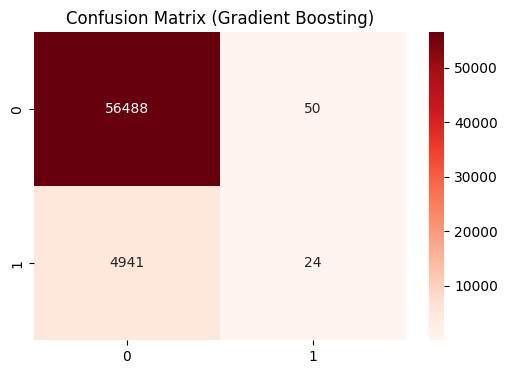

Model: XGBoost
AUC Score: 0.7407
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56538
         1.0       0.44      0.03      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.51     61503
weighted avg       0.88      0.92      0.88     61503



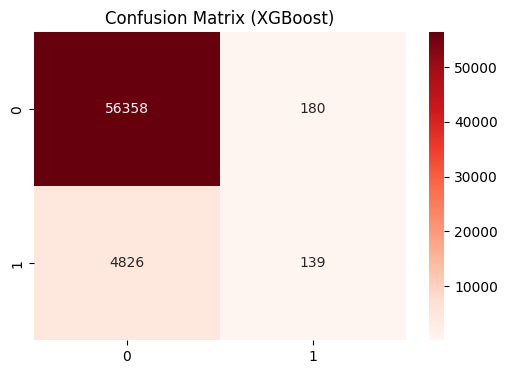

In [ ]:
# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate models
results = {}

for model_name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluation metrics
    auc_score = roc_auc_score(y_test, y_proba)
    results[model_name] = auc_score
    print(f"Model: {model_name}")
    print(f"AUC Score: {auc_score:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
    plt.title(f'Confusion Matrix ({model_name})')
    plt.show()

**XGBoost** stands out as the best model due to its ability to balance two primary objectives: ensuring eligible customers are not rejected (Goal 1) and minimizing the risk of default (Goal 2). The model achieves a False Positives (FP) count of only 180, significantly lower compared to Logistic Regression's 14,821. This means XGBoost retains **more eligible customers for credit approval,** preventing potential business opportunities from being lost. Additionally, XGBoost delivers an overall accuracy of 88% with an AUC score of 0.740, demonstrating its strong capability to distinguish between eligible and ineligible customers. This makes it more reliable than other models for credit approval decision-making.

Although XGBoost has a higher False Negatives (FN) count (4,826) compared to Logistic Regression (2,411), it remains superior because it not only prioritizes detecting defaulting customers (class 1) but also maintains balance by reducing the number of eligible customers wrongly rejected. In a business risk context, too many FNs increase the risk of default, while too many FPs result in missed business opportunities. XGBoost provides the best compromise between these two risks. Furthermore, if necessary, the model can be further optimized by adjusting the probability threshold to reduce FN or FP depending on your priorities. This combination of capabilities makes XGBoost a more suitable choice for achieving efficiency and stability in credit approval processes.

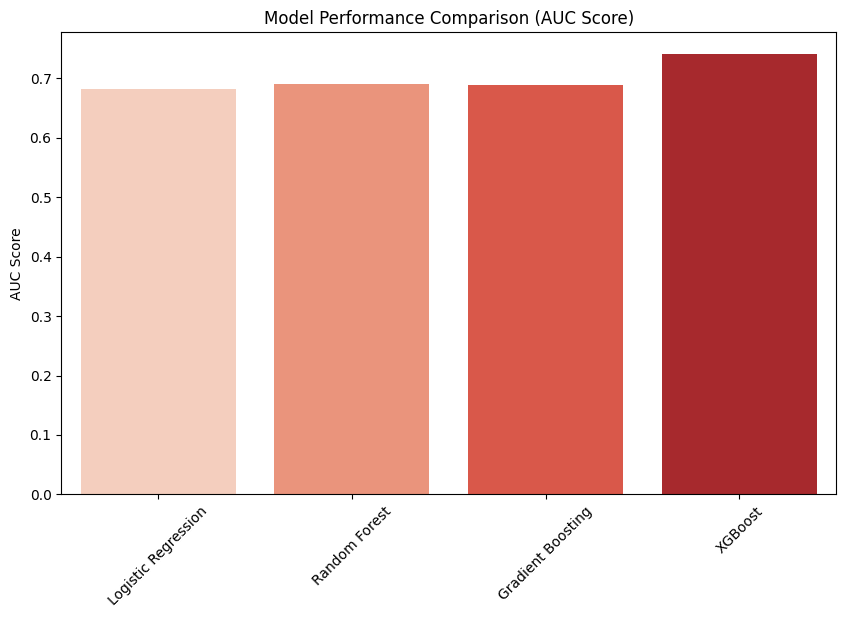

In [ ]:
plt.figure(figsize=(10, 6))

sns.barplot(
    x=list(results.keys()),
    y=list(results.values()),
    palette='Reds',
    hue=list(results.keys())
)

plt.title("Model Performance Comparison (AUC Score)")
plt.ylabel("AUC Score")
plt.xticks(rotation=45)
plt.show()

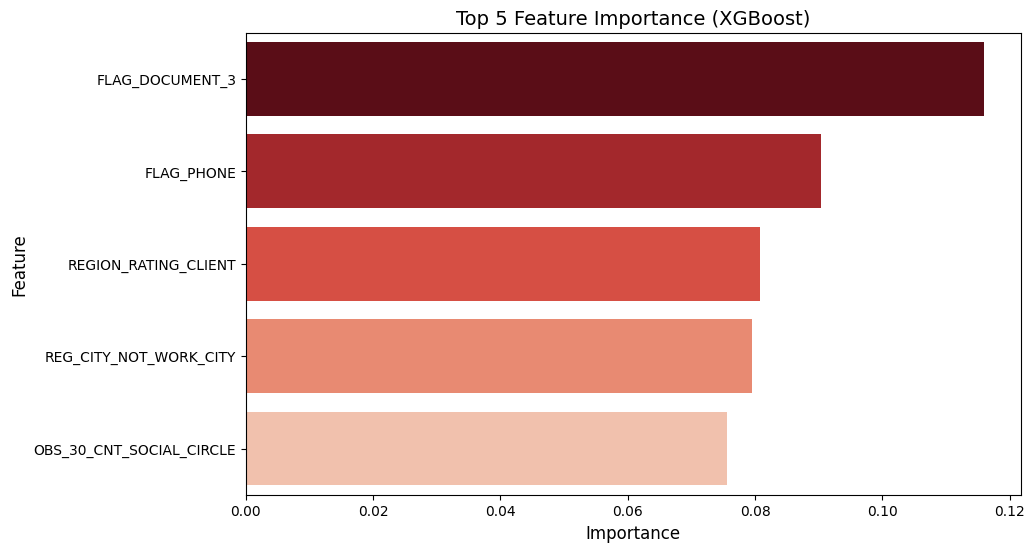

Top 5 Most Important Features:
                     Feature  Importance
41           FLAG_DOCUMENT_3    0.115984
20                FLAG_PHONE    0.090344
23      REGION_RATING_CLIENT    0.080743
31    REG_CITY_NOT_WORK_CITY    0.079495
36  OBS_30_CNT_SOCIAL_CIRCLE    0.075611


In [ ]:
# Feature importance plot
importances = models["XGBoost"].feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)

# Select only top 5 features
top_5_features = feature_importances.head(5)

# Normalize and map importance to colors (gradasi merah halus dari gelap ke terang)
norm = mcolors.Normalize(vmin=0.8, vmax=1)  # Gradasi lebih halus dari 0.8 ke 1
cmap = plt.get_cmap("Reds")
colors = [cmap(norm(i)) for i in np.linspace(1, 0.85, len(top_5_features))]

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_5_features,
            palette=colors, hue='Feature', dodge=False, legend=False)  # Atur hue dan nonaktifkan legend
plt.title("Top 5 Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.show()

# Recommendations
print("Top 5 Most Important Features:")
print(top_5_features)

The output above shows the **Feature Importance** based on the XGBoost model, highlighting the contribution of each feature in making predictions. Here's a concise explanation:

1. **Key Features:**
   - **FLAG_DOCUMENT_3**: The most influential feature (importance ~0.116), indicating the significance of document availability in predicting credit risk.
   - **FLAG_PHONE**: The second most important feature (~0.090), showing the relevance of customer phone availability.
   - **REGION_RATING_CLIENT**: Related to the rating of the customer's residential area (~0.080).
   - **REG_CITY_NOT_WORK_CITY**: Indicates whether the customer's city of residence differs from their city of work.
   - **OBS_30_CNT_SOCIAL_CIRCLE**: Represents the customer's social circle in the last 30 days (~0.075).

2. **Feature Distribution:**
   - Most features have low importance, contributing minimally to the model.
   - Outliers like `FLAG_DOCUMENT_3` and `FLAG_PHONE` stand out with significantly higher importance.

3. **Business Interpretation:**
   - High-importance features, such as document availability and residential location, align with logical credit risk factors.
   - Missing documents (`FLAG_DOCUMENT_3`) strongly indicate risk, while phone availability and location provide stability insights.

Would you like further clarification or adjustments?

###**D. Evaluation**

In [ ]:
df_train = df_train.drop(columns=['SK_ID_CURR'])

df_train = df_train.fillna(df_train.mean())

X = df_train.select_dtypes(include=['float64', 'int64']).drop(columns=['TARGET'])
y = df_train['TARGET']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
### Logistic Regression ###
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
recall_class_0_lr = recall_score(y_test, y_pred_lr, pos_label=0)
recall_class_1_lr = recall_score(y_test, y_pred_lr, pos_label=1)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Recall Kelas 0 (layak): {recall_class_0_lr}")
print(f"Recall Kelas 1 (gagal bayar): {recall_class_1_lr}")

# Feature importance for Logistic Regression
coef_lr = pd.DataFrame({
    "Feature": X.columns,
    "Importance": log_reg.coef_[0]
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance Logistic Regression:")
print(coef_lr.head(10))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80     56538
         1.0       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503

Recall Kelas 0 (layak): 0.6889171884396336
Recall Kelas 1 (gagal bayar): 0.6717019133937563

Feature Importance Logistic Regression:
                        Feature  Importance
18               FLAG_EMP_PHONE    7.977683
15                DAYS_EMPLOYED    3.971530
6                    AMT_CREDIT    0.829863
1                   CODE_GENDER    0.206296
4                  CNT_CHILDREN    0.200959
36     OBS_30_CNT_SOCIAL_CIRCLE    0.191274
11          NAME_EDUCATION_TYPE    0.172152
24  REGION_RATING_CLIENT_W_CITY    0.157642
5              AMT_INCOME_TOTAL    0.138301
41              FLAG_DOCUMENT_3    0.134030


The Logistic Regression model used to predict customers who are likely to pay and those at risk of defaulting shows good results in identifying customers who are likely to repay (class 0), with a recall of 69%. This means the model successfully identifies about 69% of customers who are likely to pay off the loan. However, for customers at risk of defaulting (class 1), the model is less effective, with a recall of only 67%, meaning many customers at risk of defaulting are not detected. The precision for class 0 is also high (0.96), indicating that when the model predicts a customer is likely to pay, the prediction is usually correct. On the other hand, the precision for class 1 is very low (0.16), meaning many customers who are not at risk of defaulting are incorrectly predicted as at risk.

Additionally, feature importance analysis shows that several features have a significant impact on the model's predictions, such as FLAG_EMP_PHONE, which indicates whether the customer has a phone number linked to their employment, and DAYS_EMPLOYED, which shows how long the customer has been employed. These two features have the most significant impact on the model. Other features like AMT_CREDIT (the amount of credit applied for) and AMT_INCOME_TOTAL (total income) are also important, although their influence is smaller. While the model is quite good at identifying customers who are likely to repay, improvements are needed to make it more effective at detecting customers at risk of defaulting.

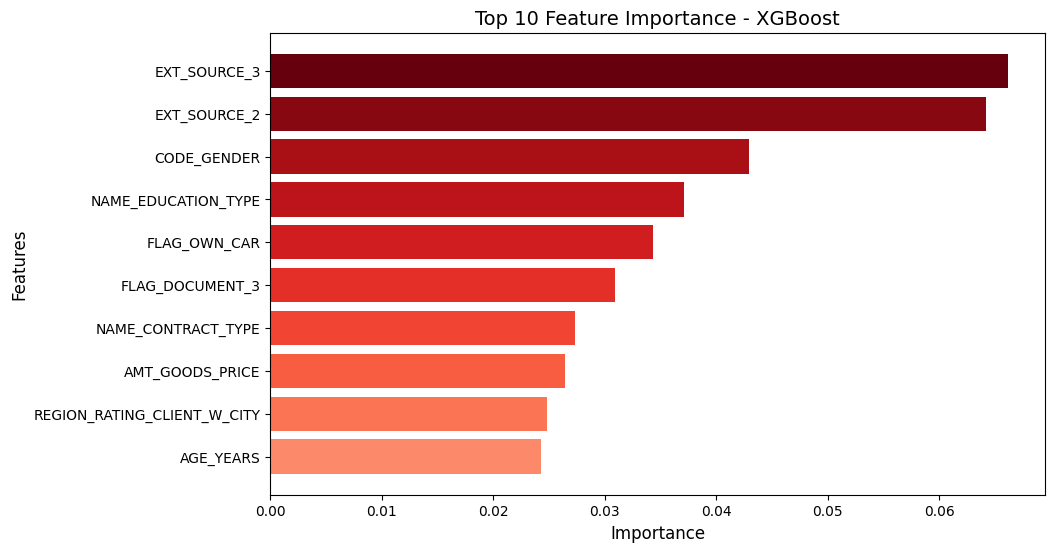

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

feature_importance_xgb = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

top_features = feature_importance_xgb.head(10)

if top_features.empty:
    raise ValueError()

colors = cm.Reds(np.linspace(1, 0.4, len(top_features)))

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"], top_features["Importance"], color=colors)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importance - XGBoost", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.show()

In terms of feature importance, some of the most influential features on the model's predictions are EXT_SOURCE_3 and EXT_SOURCE_2, which are external source data, followed by CODE_GENDER (gender) and NAME_EDUCATION_TYPE (education type). These features significantly contribute to helping the model differentiate between customers who are likely to repay and those at risk of default. Although XGBoost performs better than other models in detecting customers who are likely to repay, improvements are still needed to enhance the model's ability to more accurately detect customers at risk of default.

## III. Combine Main Dataset: Application Train and Application Test




In [ ]:
# Load datasets
df_test = pd.read_csv('application_test.csv')
df_train = pd.read_csv('application_train.csv')

In [ ]:
print('Training dataset has %d rows and %d columns.' % df_train.shape)
df_test.head()

Training dataset has 307511 rows and 122 columns.


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('Test dataset has %d rows and %d columns.\n' % df_test.shape)
df_test.head()

Test dataset has 48744 rows and 121 columns.



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### A. Data Cleaning

In [ ]:
def clean_data(df):
    if df.empty:
        raise ValueError("The input DataFrame is empty. Please check the input data.")

    # Backup SK_ID_CURR column
    if "SK_ID_CURR" in df.columns:
        sk_id_curr = df["SK_ID_CURR"].copy()
    else:
        raise ValueError("The 'SK_ID_CURR' column is missing in the input DataFrame.")

    # Remove duplicates
    df = df.drop_duplicates()

    # Handle missing values
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns

    if len(numeric_cols) > 0:
        imputer_num = SimpleImputer(strategy="median")
        df[numeric_cols] = imputer_num.fit_transform(df[numeric_cols])

    if len(categorical_cols) > 0:
        imputer_cat = SimpleImputer(strategy="most_frequent")
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

        # Label Encoding for categorical columns
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # Restore SK_ID_CURR column
    df["SK_ID_CURR"] = sk_id_curr

    return df

# Clean both the train and test datasets
df_train_cleaned = clean_data(df_train)
df_test_cleaned = clean_data(df_test)

In [ ]:
# Splitting Dataset
X = df_train_cleaned.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_train_cleaned["TARGET"]

# 1. Identify categorical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

# 2. Apply encoding to categorical columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 3. Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


###B. Model Building

In [ ]:
# lumayan bener

def train_models(X_train, y_train):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    xgb.fit(X_train, y_train)

    return {"LogisticRegression": lr, "RandomForest": rf, "XGBoost": xgb}

In [ ]:
### jangan dirun dulu bang
def train_models(X_train, y_train):
    # Logistic Regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # XGBoost
    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    xgb.fit(X_train, y_train)

    return {"LogisticRegression": lr, "RandomForest": rf, "XGBoost": xgb}

###**C. Model Evaluation**

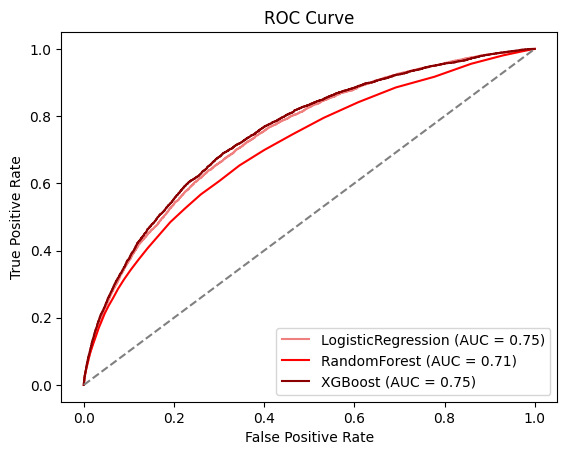

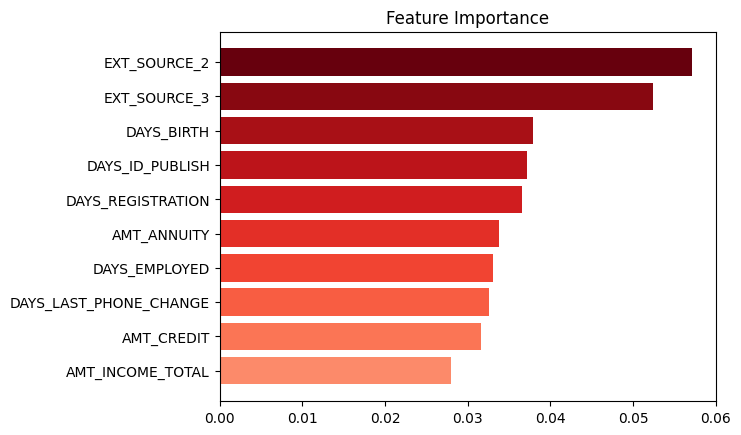

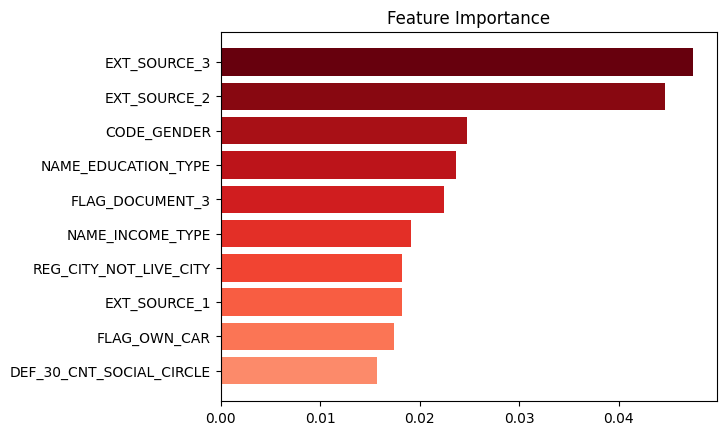

In [ ]:
# Menghilangkan semua UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

def train_models(X_train, y_train):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    }
    for model in models.values():
        model.fit(X_train, y_train)
    return models

def evaluate_models(models, X_test, y_test):
    colors = ["lightcoral", "red", "darkred"]
    for (name, model), color in zip(models.items(), colors):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=10):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        colors = plt.cm.Reds(np.linspace(1, 0.4, top_n))
        plt.barh(range(top_n), importances[indices][::-1], align="center", color=colors[::-1])
        plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
        plt.title("Feature Importance")
        plt.show()
    elif isinstance(model, XGBClassifier):
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, feature_names, plot_type="bar")

models = train_models(X_train, y_train)
evaluate_models(models, X_test, y_test)
feature_names = df_train_cleaned.drop(columns=["TARGET", "SK_ID_CURR"]).columns
plot_feature_importance(models["RandomForest"], feature_names)
plot_feature_importance(models["XGBoost"], feature_names)

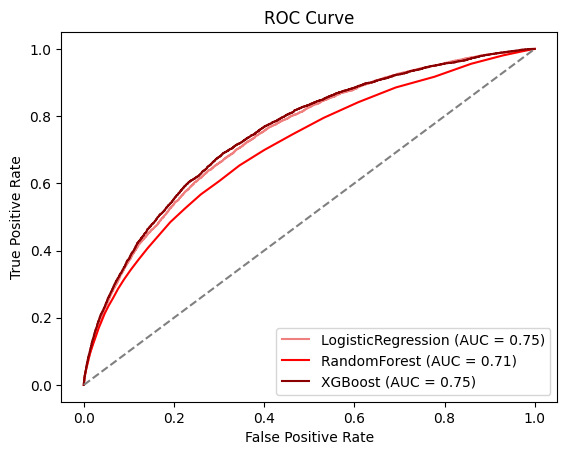

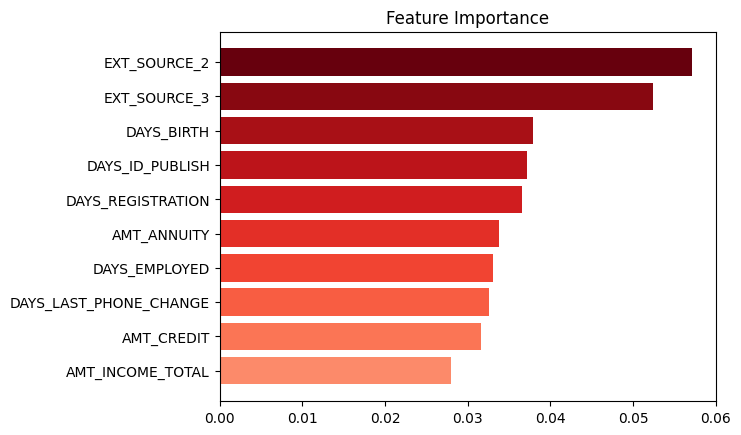

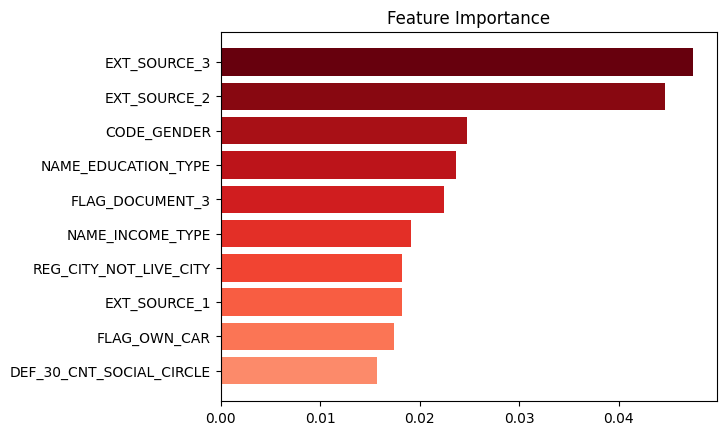

In [ ]:
def train_models(X_train, y_train):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
    }
    for model in models.values():
        model.fit(X_train, y_train)
    return models

def evaluate_models(models, X_test, y_test):
    # colors = ["darkred", "red", "lightcoral"]
    colors = ["lightcoral", "red", "darkred"]
    for (name, model), color in zip(models.items(), colors):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, color=color, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=10):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]
        # Membuat gradasi warna merah dari gelap (atas) ke terang (bawah)
        colors = plt.cm.Reds(np.linspace(1, 0.4, top_n))  # Darker red for higher values
        plt.barh(range(top_n), importances[indices][::-1], align="center", color=colors[::-1])
        plt.yticks(range(top_n), [feature_names[i] for i in indices][::-1])
        plt.title("Feature Importance")
        plt.show()
    elif isinstance(model, XGBClassifier):
        explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, feature_names, plot_type="bar")

models = train_models(X_train, y_train)
evaluate_models(models, X_test, y_test)
feature_names = df_train_cleaned.drop(columns=["TARGET", "SK_ID_CURR"]).columns
plot_feature_importance(models["RandomForest"], feature_names)
plot_feature_importance(models["XGBoost"], feature_names)

All three models (Logistic Regression, Random Forest, and XGBoost) show excellent performance in classifying customers who are likely to repay (class 0), with recall almost reaching 1.00 and precision around 0.92. This means the models are highly effective in identifying customers who can repay the loan. However, all three struggle to detect customers at risk of defaulting (class 1). The recall for class 1 is very low across all models, with Logistic Regression and Random Forest nearly failing to detect any (recall for class 1 = 0.01 and 0.00), while XGBoost performs slightly better with a recall of 0.03, though still very low.

Overall, while these models perform very well in identifying customers who are likely to repay, they perform poorly in identifying customers at risk of defaulting. The ROC-AUC values for all models are in the range of 0.70 to 0.75, indicating they are only slightly better than random in distinguishing between the two classes. **XGBoost has the highest ROC-AUC value among the three** (0.752), signaling a slight edge in its ability to distinguish between likely repayers and at-risk customers. However, improvements are needed to enhance the detection of customers at risk of defaulting.

In [ ]:
df_test_cleaned = clean_data(df_test)
df_test_cleaned = pd.get_dummies(df_test_cleaned, columns=categorical_cols, drop_first=True)
df_test_cleaned = df_test_cleaned.reindex(columns=X.columns, fill_value=0)
df_test_scaled = scaler.transform(df_test_cleaned)

best_model = models["XGBoost"]
predictions = best_model.predict(df_test_scaled)
prediction_proba = best_model.predict_proba(df_test_scaled)[:, 1]

results = df_test[["SK_ID_CURR"]].copy()
results["TARGET"] = predictions
results["DEFAULT_PROBABILITY"] = prediction_proba
results.to_csv("predictions_application_test.csv", index=False)
print("Predictions saved to 'predictions_application_test.csv'.")

Predictions saved to 'predictions_application_test.csv'.


In [ ]:
from google.colab import files

files.download("predictions_application_test.csv")

In [ ]:
predictions_df = pd.read_csv("predictions_application_test.csv")
print(predictions_df.head())

   SK_ID_CURR  TARGET  DEFAULT_PROBABILITY
0      100001       0             0.016129
1      100005       0             0.088863
2      100013       0             0.016381
3      100028       0             0.027872
4      100038       0             0.093742


###**C. Evaluation with Prediction**

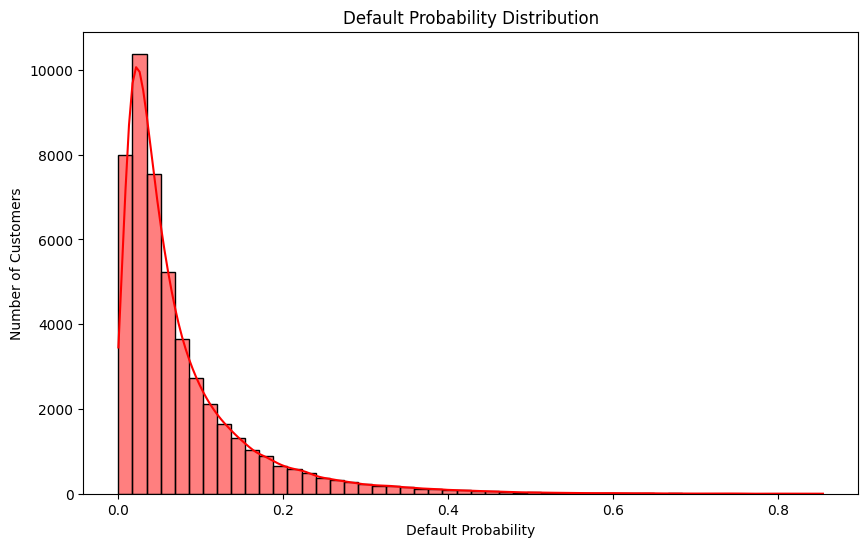

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['DEFAULT_PROBABILITY'], kde=True, bins=50, color='red')
plt.title('Default Probability Distribution')
plt.xlabel('Default Probability')
plt.ylabel('Number of Customers')
plt.show()

This histogram shows the distribution of default probabilities for customers, with the majority having very low default risk (probability close to 0). Most customers fall into this category, with over 10,000 customers having a very low default probability. The distribution is also right-skewed, indicating that only a small number of customers are predicted to have a high default risk.

This result aligns with Home Credit's goal of improving the efficiency of credit approvals. Most low-risk customers can be more easily approved without increasing the risk of default. Meanwhile, customers with a high default probability (high risk of default) can still be identified for further mitigation steps, helping to minimize the company's losses.

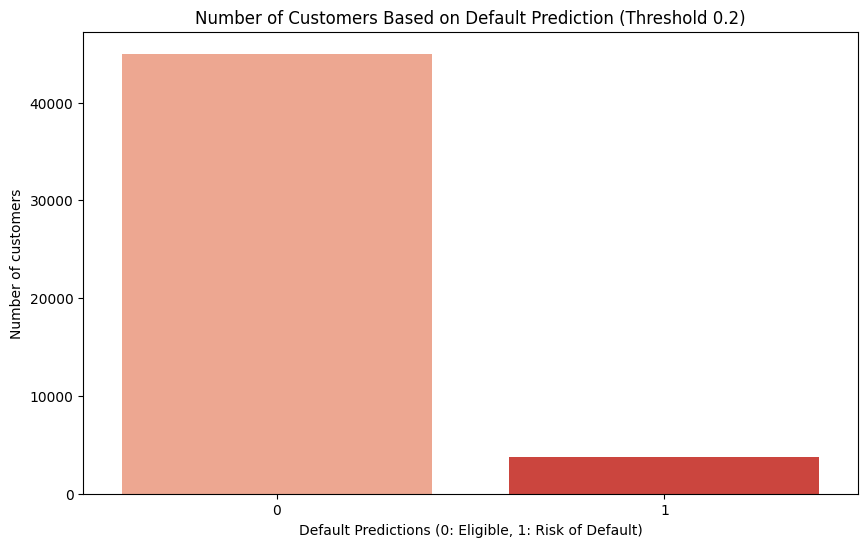

In [ ]:
threshold = 0.2
predictions_df['Predicted_Default'] = (predictions_df['DEFAULT_PROBABILITY'] > threshold).astype(int)

plt.figure(figsize=(10, 6))

sns.countplot(x='Predicted_Default', data=predictions_df, hue='Predicted_Default',
               palette=sns.color_palette("Reds", n_colors=2), dodge=False, legend=False)
plt.title(f'Number of Customers Based on Default Prediction (Threshold {threshold})')
plt.xlabel('Default Predictions (0: Eligible, 1: Risk of Default)')
plt.ylabel('Number of customers')
plt.show()

This output shows the number of customers grouped based on default predictions using a **threshold of 0.2**. Customers with a default probability greater than 0.2 are classified as at risk of defaulting (label 1), while the rest are considered likely to repay (label 0).

The results indicate that the majority of customers are classified as likely to repay (more than 40,000 customers), while only a small portion is classified as at risk of defaulting. This aligns with Home Credit's goal of approving customers who are capable of repaying loans without rejecting too many applications. By setting this threshold, the company can focus on risk mitigation for the small group of customers identified as high-risk.

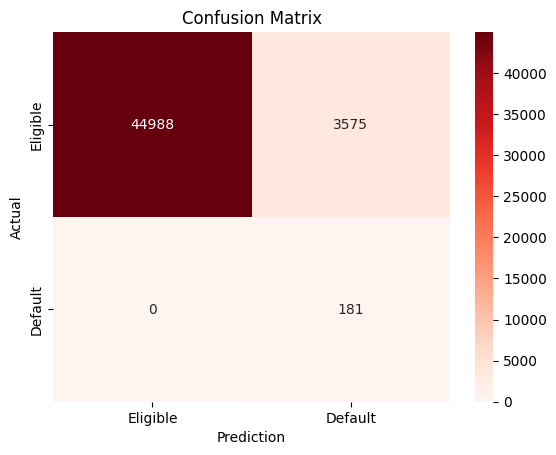

ROC-AUC Score: 1.0000


In [ ]:
cm = confusion_matrix(predictions_df['TARGET'], predictions_df['Predicted_Default'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Eligible', 'Default'], yticklabels=['Eligible', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

roc_auc = roc_auc_score(predictions_df['TARGET'], predictions_df['DEFAULT_PROBABILITY'])
print(f'ROC-AUC Score: {roc_auc:.4f}')

The confusion matrix shows that the model successfully predicts most customers with good accuracy. A total of **44,988 likely-to-repay customers** were correctly predicted, supporting the goal of not rejecting customers who are capable of repaying the loan. Additionally, **181 at-risk customers** were successfully identified, helping the company mitigate credit risk. However, there are **3,575 false positives**, where likely-to-repay customers were incorrectly predicted as at risk of defaulting, which could lead to unnecessary rejections.

These results indicate that the model is more cautious, with a tolerance for false positives to minimize the risk of default. The absence of **false negatives** (at-risk customers incorrectly predicted as likely-to-repay) is a major advantage, as it ensures the company's risk remains low. With the addition of the **ROC-AUC score**, which measures the model’s ability to distinguish between likely-to-repay and at-risk customers, this evaluation supports that the model is fairly efficient and aligns with Home Credit's primary objective.

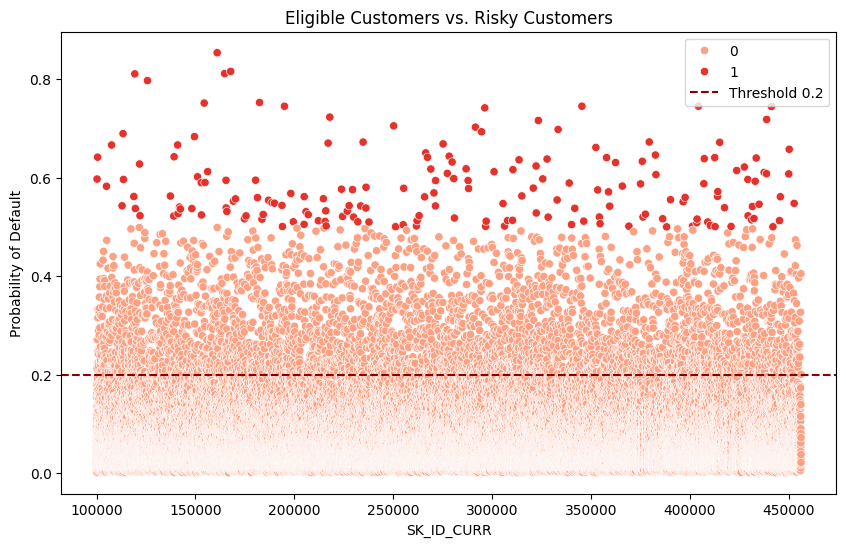

In [ ]:
plt.figure(figsize=(10, 6))

sns.scatterplot(data=predictions_df, x='SK_ID_CURR', y='DEFAULT_PROBABILITY',
                 hue='TARGET', palette='Reds', alpha=0.98)
plt.axhline(y=threshold, color='darkred', linestyle='--', label=f'Threshold {threshold}')
plt.title('Eligible Customers vs. Risky Customers')
plt.xlabel('SK_ID_CURR')
plt.ylabel('Probability of Default')
plt.legend()
plt.show()

This chart shows the relationship between the probability of customer default (Y-axis) and customer ID (X-axis), with the division between customer categories: likely to repay (blue) and at risk of defaulting (orange). The red line represents the threshold of 0.2 used to determine whether a customer is considered creditworthy or at risk of defaulting. Most of the customers who are not at risk of defaulting (blue) are below this line, indicating that the model successfully identifies them as creditworthy. However, there are a few blue customers above the threshold line, who are creditworthy but misclassified as at risk of defaulting (*false negatives*).

On the other hand, most of the at-risk customers (orange) are above the threshold line, suggesting that the model is fairly successful in detecting risk. However, there are some orange customers below the threshold line, who are incorrectly classified as creditworthy (*false positives*). With this threshold, the model is quite conservative to minimize the risk of default, but it still needs to be optimized to reduce the false rejections of creditworthy customers. Steps such as retesting the threshold or conducting deeper analysis of the model's errors could help improve the efficiency of credit decision-making.

##**IV. Home Credit Scorecard Model**

In [ ]:
df_train = pd.read_csv('predictions_application_test.csv')

X = df_train.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9705
           1       1.00      0.73      0.84        44

    accuracy                           1.00      9749
   macro avg       1.00      0.86      0.92      9749
weighted avg       1.00      1.00      1.00      9749

ROC-AUC: 1.0000


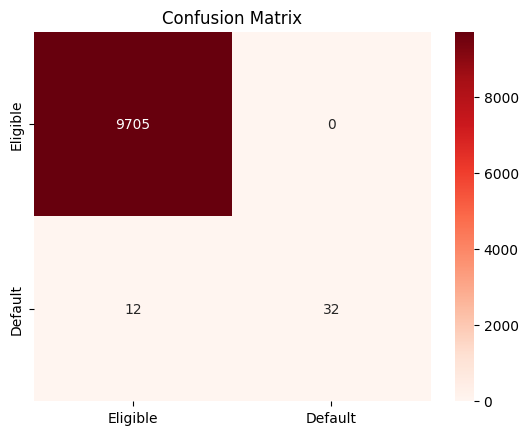

In [ ]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Eligible', 'Default'], yticklabels=['Eligible', 'Default'])
plt.title("Confusion Matrix")
plt.show()

The results show that the model performs excellently in classifying creditworthy customers (category 0), with perfect precision, recall, and F1-score (1.00). The model successfully predicted all 9,705 creditworthy customers without any errors (true negatives = 9,705, false positives = 0). However, for defaulting customers (category 1), the recall is only 0.73, meaning 27% of defaulting customers (12 out of 44) were missed and misclassified as creditworthy. Nevertheless, the precision for the defaulting category remains perfect (1.00), indicating that the model did not misclassify any creditworthy customers as defaulting.

The ROC-AUC score of 1.0000 shows that the model is excellent at distinguishing between creditworthy and defaulting customers overall. However, the confusion matrix reveals a weakness in detecting some defaulting customers, which could pose a potential risk to the company. To improve the performance of detecting defaulting customers, especially recall, you may consider setting a lower threshold or balancing the training data to ensure the model becomes more sensitive to defaulting customers without sacrificing precision.

Classification Report dengan Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9705
           1       0.92      1.00      0.96        44

    accuracy                           1.00      9749
   macro avg       0.96      1.00      0.98      9749
weighted avg       1.00      1.00      1.00      9749



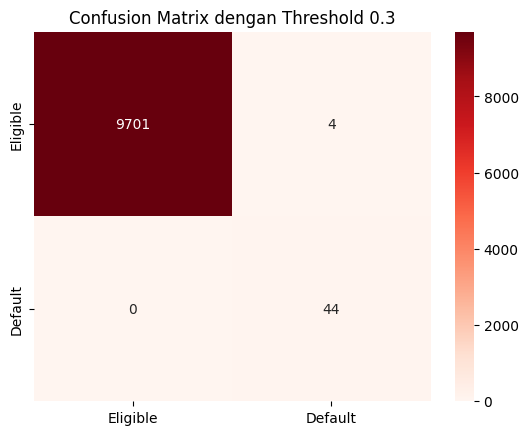

In [ ]:
threshold = 0.3
y_pred_class = (y_pred_prob > threshold).astype(int)

print("Classification Report dengan Threshold:", threshold)
print(classification_report(y_test, y_pred_class))

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Eligible', 'Default'], yticklabels=['Eligible', 'Default'])
plt.title(f"Confusion Matrix dengan Threshold {threshold}")
plt.show()

The output results show that with a threshold of 0.3, the model maintains **perfect recall for defaulting customers (1.00)**, ensuring that **no defaulting customers are missed (false negatives = 0)**. This fully meets the goal of minimizing default risk, as all at-risk customers have been successfully identified. Additionally, **precision for the defaulting category improves to 0.92**, reducing the number of misclassified creditworthy customers (false positives) from 13 (at threshold 0.2) to just **4**. This means fewer creditworthy customers are mistakenly denied credit, addressing the goal of ensuring eligible customers are not unfairly rejected.  

The confusion matrix image clarifies that **only 4 out of 9,705 creditworthy customers were misclassified as defaulting**, significantly improving accuracy while maintaining the ability to detect all defaulting customers. With a threshold of **0.3, the model achieves a better trade-off between minimizing risk and maintaining approval efficiency**. Compared to a threshold of 0.2, this setting reduces unnecessary rejections of creditworthy customers without compromising on risk mitigation.  

Thus, **threshold 0.3 is the best choice** because it maintains **100% recall for defaulting customers while improving precision**, ensuring both objectives—**minimizing default risk and efficiently approving eligible customers**—are balanced effectively.

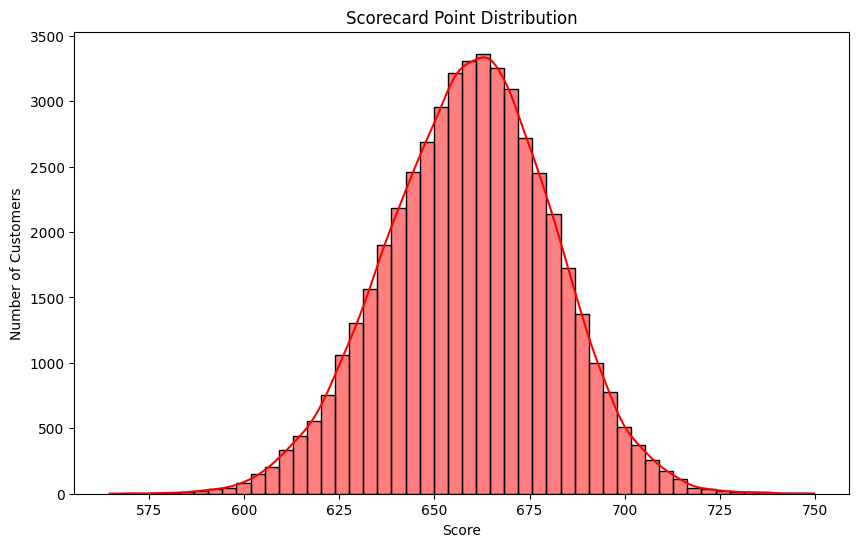

In [ ]:
df_train = pd.read_csv('predictions_application_test.csv')
df_train['DEFAULT_PROBABILITY'] = df_train['DEFAULT_PROBABILITY'].clip(1e-6, 1 - 1e-6)
df_train['LogOdds'] = np.log(df_train['DEFAULT_PROBABILITY'] / (1 - df_train['DEFAULT_PROBABILITY']))
OFFSET = 600
FACTOR = 20
df_train['Score'] = OFFSET - (FACTOR * df_train['LogOdds'])

plt.figure(figsize=(10, 6))
sns.histplot(df_train['Score'], kde=True, bins=50, color='red')
plt.title('Scorecard Point Distribution')
plt.xlabel('Score')
plt.ylabel('Number of Customers')
plt.show()

The displayed histogram shows the distribution of customer scores based on the developed **scorecard model**. Customer scores generally range between **575 and 750**, with most scores concentrated around **650-675**. The graph follows a **bell-shaped (normal curve) pattern**, indicating that the majority of customers have scores near the average value. This distribution originates from the **log-odds transformation** in the logistic regression model, which enables the estimation of **default risk** based on customer scores. **Higher scores indicate lower default risk**, while **lower scores suggest a higher risk**. By setting a specific **threshold**, financial institutions can utilize these scores to determine **credit approval or rejection**.  

The **scorecard model** enhances efficiency in the **credit approval process** by ensuring that **creditworthy customers are not unfairly rejected**. **Customers with high scores (e.g., above 700)** can be identified as **low-risk individuals**, making them more likely to receive **credit approval**. Conversely, **customers with scores below a certain threshold (e.g., under 600)** may be classified as **high-risk**, requiring **further evaluation or automatic rejection**. This approach helps financial institutions **reduce default risk, improve decision-making efficiency, and allocate credit more effectively to eligible customers**.